<a href="https://colab.research.google.com/github/Flexecstasy/d4rksIde/blob/master/%D0%A7%D1%91%D1%80%D0%BD%D0%B0%D1%8F_%D0%BF%D1%8F%D1%82%D0%BD%D0%B8%D1%86_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'black-friday-sale:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2758244%2F4765161%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240805%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240805T163942Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8bc39760866fe234ded9314c9d0c96ddb77c1476111116fb3c5d75bd1b0536c1a704c0c8621d3ccc5f5d24e435c6ba5cf76fea962fe264408ac3ef2ed5cee01c12bce3f86bf64d23f021fbca9417f529ee1d208077e266f7c54446148f596e61ea27d2bfe3dee72300ab1f71e574b521ce007565efd1bf31f057edc865eb9eaa657f90bf892f5fe79c93024d6dfa88108814fa832d3ce0a30b683c121b7986a9a8b29e06bbfd514288ec072e2bb8339f07d9c418a2f6db951383c760f4bac060f1233ab6f24ae9a3f42c1259a9dcb8a7a093d5969c90e6e3d3b9ba535fac7c0ff1b1344c8941ea8239a816a480a35aa4feeee6e5d6a364ea0963b361b57b8886'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 5744184 bytes downloaded
Downloaded and uncompressed: black-friday-sale
Data source import complete.


In [75]:

import pandas as pd # Библиотека для считывания csv-файлов

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/black-friday-sale/train.csv


In [76]:
import matplotlib.pyplot as plt # Библиотека для построения графиков
import seaborn as sns # Библиотека для построения статистических графиков
from sklearn import svm, preprocessing

In [77]:
df=pd.read_csv('/kaggle/input/black-friday-sale/train.csv') # Считываем данные из файла
df.info() # Выводим информацию о датасете
df.head(5) # Выводим первые 5 строк датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [78]:
df.describe() # Выводим статистическую информацию о датасете

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [79]:
plt.style.use('ggplot') # Устанавливаем стиль графиков


# Распределение покупок

<Axes: title={'center': 'Распределение покупок'}, ylabel='Frequency'>

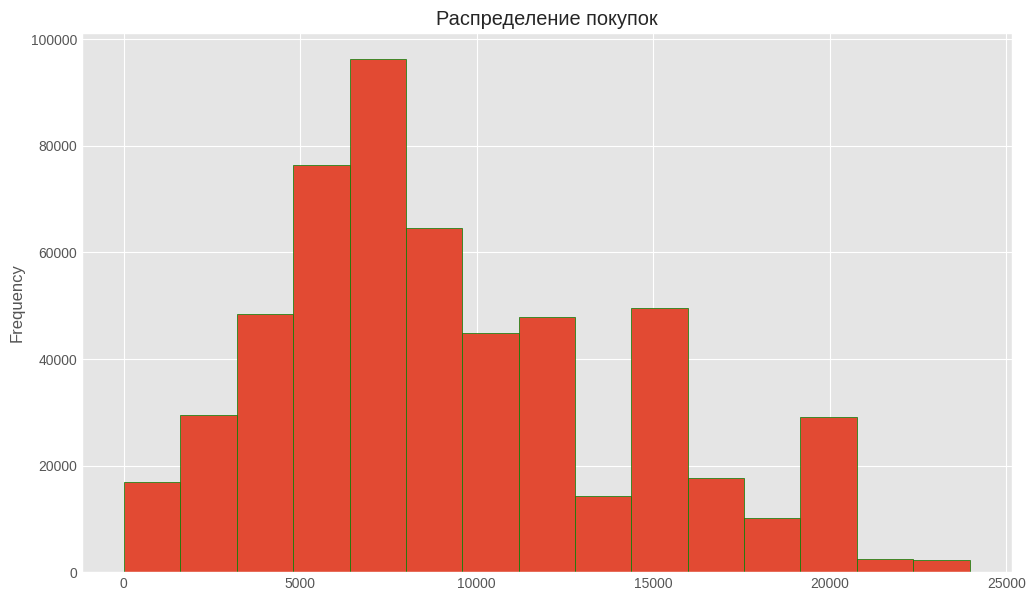

In [80]:
purchase_d=df['Purchase']
purchase_d.plot(kind='hist',bins=15,
       edgecolor = 'green',figsize=(12,7),title='Распределение покупок') # Строим гистограмму распределения покупок

# Распределение по полу

In [81]:
df.head() # Выводим первые 5 строк датасета

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


<ipython-input-82-4bccb1c2ba48>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


array([<Axes: ylabel='User_ID'>], dtype=object)

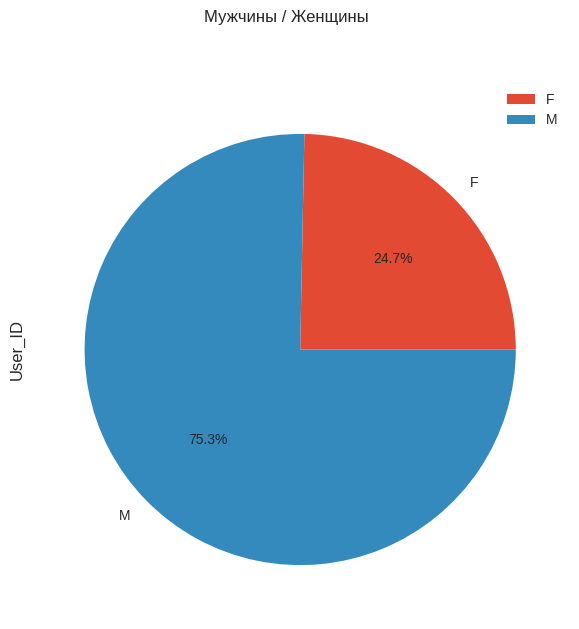

In [82]:
gender_count=df[['Gender','User_ID']].groupby('Gender').count()
gender_count
plt.style.use('seaborn-whitegrid')
gender_count.plot(kind='pie',autopct='%1.1f%%',subplots=True,title='Мужчины / Женщины',figsize=(11,7)) # Строим круговую диаграмму распределения по полу

# Соотношение мужчин и женщин по общему количеству покупок

array([<Axes: ylabel='Purchase'>], dtype=object)

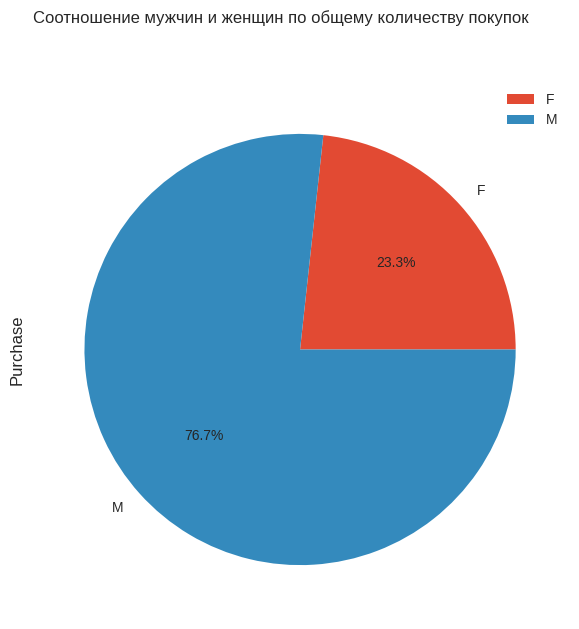

In [83]:
gender_pu=df[['Gender','Purchase']].groupby('Gender').sum()
gender_pu
gender_pu.plot(kind='pie',autopct='%1.1f%%',subplots=True,figsize=(15,7),title='Соотношение мужчин и женщин по общему количеству покупок') # Строим круговую диаграмму распределения по полу

# Покупки в зависимости от семейного положения

array([<Axes: ylabel='Purchase'>], dtype=object)

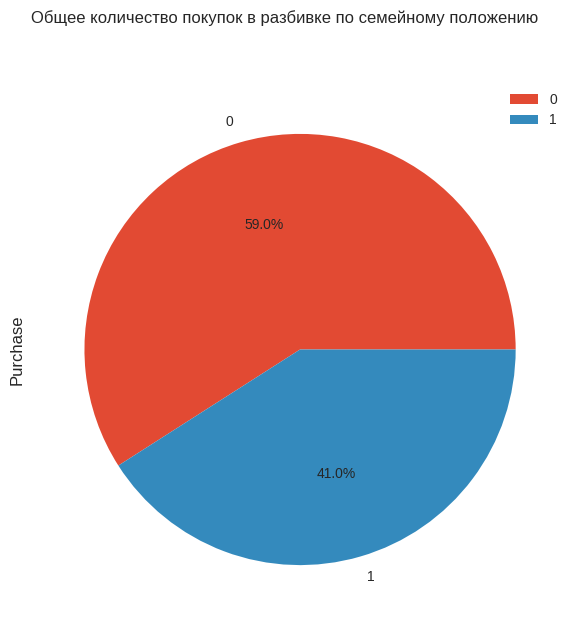

In [84]:
status_pu=df[['Marital_Status','Purchase']].groupby('Marital_Status').sum()
status_pu.plot(kind='pie',title='Общее количество покупок в разбивке по семейному положению',autopct='%1.1f%%',subplots=True,figsize=(12,7)) # Строим круговую диаграмму распределения по полу

**Неженатые люди покупают на 17% больше**

# Статус занятости:

<Axes: title={'center': 'Зависимость покупок от наличия работы'}, ylabel='Frequency'>

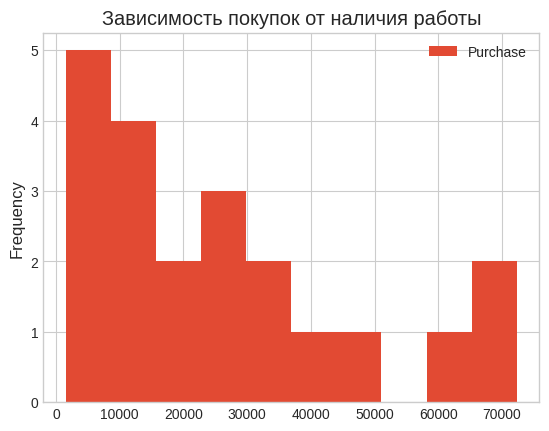

In [85]:
ocu_count=df[['Occupation','Purchase']].groupby('Occupation').count()
ocu_count=ocu_count.sort_values(by='Purchase',ascending=False)
ocu_count.plot(kind='hist',title='Зависимость покупок от наличия работы') # Строим гистограмму распределения покупок

# Purchases by occupation:

<Axes: title={'center': 'Общее количество покупок в разбивке по профессиям'}, xlabel='Occupation'>

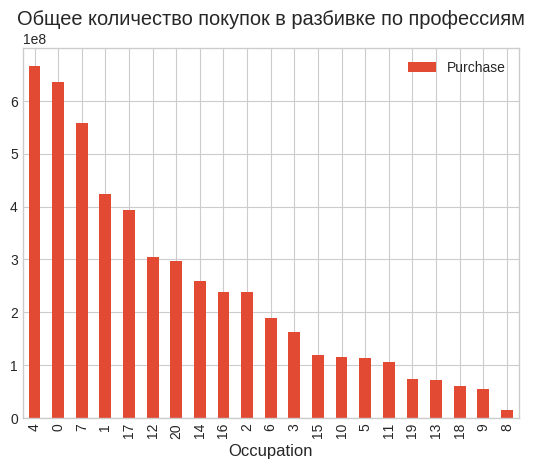

In [86]:
ocu_pu=df[['Occupation','Purchase']].groupby('Occupation').sum()
ocu_pu=ocu_pu.sort_values(by='Purchase',ascending=False)
ocu_pu.plot(kind='bar',title='Общее количество покупок в разбивке по профессиям')

# Количество покупок в зависимости о города

array([<Axes: ylabel='Purchase'>], dtype=object)

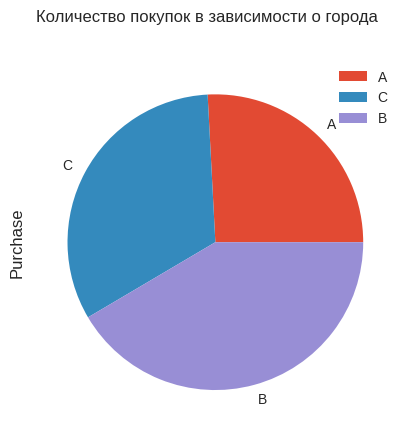

In [87]:
city_pu=df[['City_Category','Purchase']].groupby('City_Category').sum()
city_pu=city_pu.sort_values(by='Purchase')
city_pu.plot(kind='pie',subplots=True,title='Количество покупок в зависимости о города')

**Как видим из диаграммы, больше вспего продаж магазин имеет в городе B**

**Разбиение по возрастным группам**

<Axes: ylabel='Age'>

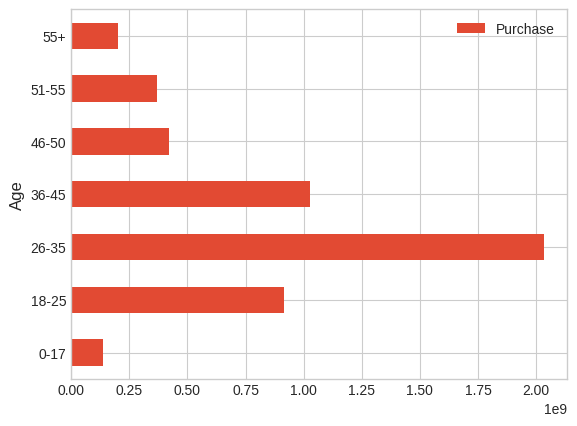

In [88]:

age_pu=df[['Age','Purchase']].groupby('Age').sum()
age_pu.plot(kind='barh')


# Анализ товарной категории

<Axes: title={'center': 'Категория 1 товара  по покупкам'}, ylabel='Product_Category_1'>

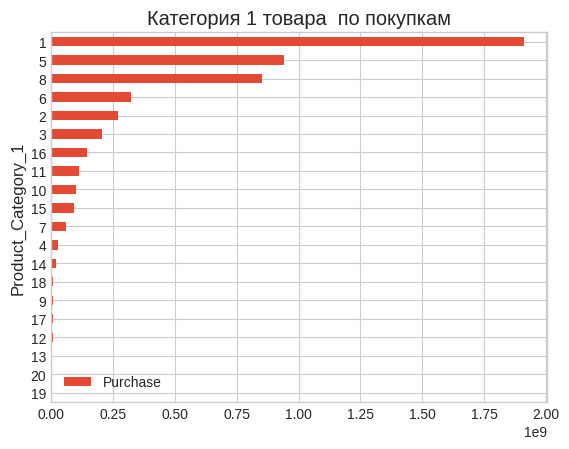

In [89]:
prod_pu1=df[['Product_Category_1','Purchase']].groupby('Product_Category_1').sum()
prod_pu1=prod_pu1.sort_values(by='Purchase')
prod_pu1.plot(kind='barh',title='Категория 1 товара  по покупкам')


<Axes: title={'center': 'Категория 2 товара  по покупкам'}, ylabel='Product_Category_1'>

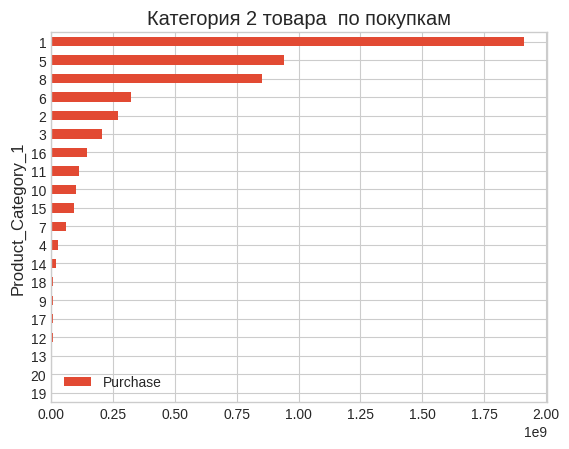

In [90]:

prod_pu2=df[['Product_Category_2','Purchase']].groupby('Product_Category_2').sum()
prod_pu2=prod_pu1.sort_values(by='Purchase')
prod_pu2.plot(kind='barh',title='Категория 2 товара  по покупкам')


<Axes: title={'center': 'Категория 3 товара  по покупкам'}, ylabel='Product_Category_1'>

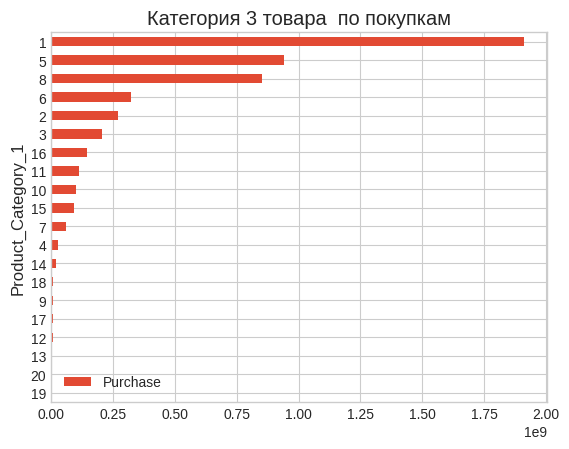

In [91]:
prod_pu3=df[['Product_Category_3','Purchase']].groupby('Product_Category_3').sum()
prod_pu3=prod_pu1.sort_values(by='Purchase')
prod_pu3.plot(kind='barh',title='Категория 3 товара  по покупкам')


# Диаграмма самых продаваемых товаров

array([<Axes: >], dtype=object)

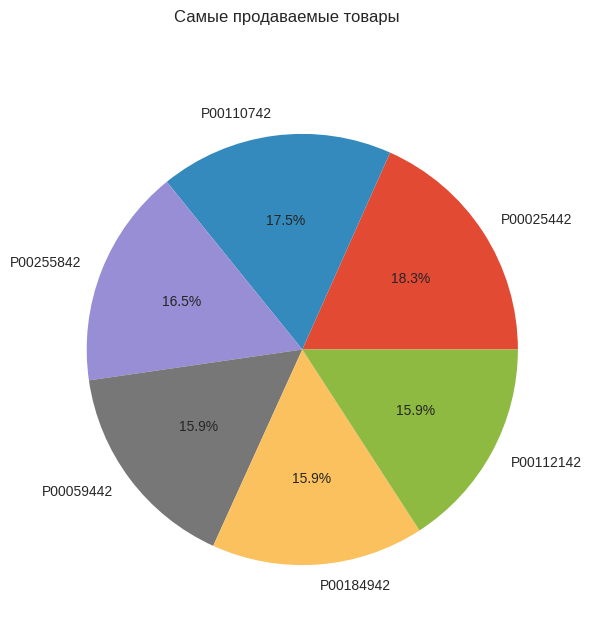

In [92]:
top_prod=df[['Product_ID','Purchase']].groupby('Product_ID').sum()
top_prod=top_prod.sort_values(by='Purchase',ascending=False)
top_prod=top_prod.head(6)
top_prod.plot(kind='pie',title='Самые продаваемые товары',subplots=True,autopct='%1.1f%%',legend=False,ylabel='',figsize=(12,7))

# Зависимость проживания от количества покупок

<Axes: title={'center': 'Зависимость проживания от количества покупок'}, xlabel='Years', ylabel='Years'>

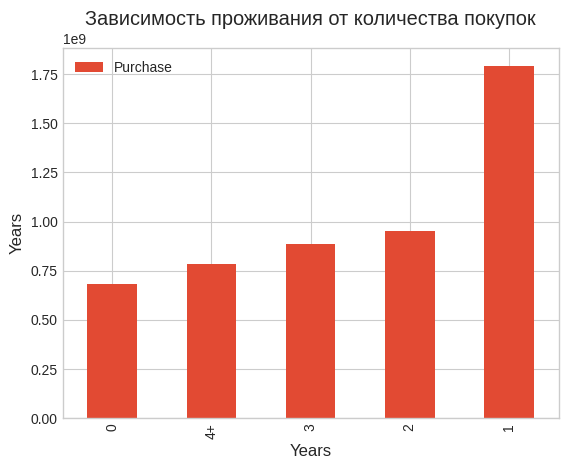

In [93]:
city_dur=df[['Stay_In_Current_City_Years','Purchase']].groupby('Stay_In_Current_City_Years').sum()
city_dur=city_dur.sort_values(by='Purchase')
city_dur.plot(kind='bar',xlabel='Years',ylabel='Years',title='Зависимость проживания от количества покупок')

**Чем дольше покупатели остаются в городе, тем больше сокращается объем их покупок.**

# Коррелируем наши данные:

In [94]:
df2=df.copy()

**Data encoding:**

In [95]:
df2['Gender']=pd.factorize(df2.Gender)[0]
df2['Age']=pd.factorize(df2.Age)[0]
df2['City_Category']=pd.factorize(df2.City_Category)[0]
df2['Stay_In_Current_City_Years']=pd.factorize(df2.Stay_In_Current_City_Years)[0]
df2['Product_ID']=pd.factorize(df2.Product_ID)[0]
df2['User_ID']=pd.factorize(df2.User_ID)[0]




In [96]:
df2['Product_Category_1']=pd.factorize(df2.Product_Category_1)[0]
df2['Product_Category_2']=pd.factorize(df2.Product_Category_2)[0]
df2['Product_Category_3']=pd.factorize(df2.Product_Category_3)[0]

In [97]:
df2.corr()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,0.004389,-0.038275,-0.039948,-0.023348,0.023497,0.003509,0.025181,0.010296,0.002447,0.000739,0.006735
Product_ID,0.004389,1.000000,-0.016938,-0.006908,-0.004188,-0.013383,0.007775,0.013193,0.286762,-0.077515,-0.173713,-0.249081
Gender,-0.038275,-0.016938,1.000000,-0.000777,0.117291,-0.007688,-0.015108,-0.011603,-0.006406,0.021938,0.037288,0.060346
Age,-0.039948,-0.006908,-0.000777,1.000000,-0.040858,0.042006,0.007013,-0.078776,-0.006687,0.004906,0.008081,0.002344
Occupation,-0.023348,-0.004188,0.117291,-0.040858,1.000000,0.005470,-0.010470,0.024280,0.003964,0.008461,0.008824,0.020833
City_Category,0.023497,-0.013383,-0.007688,0.042006,0.005470,1.000000,-0.011205,0.016846,-0.006594,0.011255,0.011226,0.011513
Stay_In_Current_City_Years,0.003509,0.007775,-0.015108,0.007013,-0.010470,-0.011205,1.000000,0.010461,0.003440,-0.001197,-0.004844,-0.007504
Marital_Status,0.025181,0.013193,-0.011603,-0.078776,0.024280,0.016846,0.010461,1.000000,0.011935,-0.002574,-0.010064,-0.000463
Product_Category_1,0.010296,0.286762,-0.006406,-0.006687,0.003964,-0.006594,0.003440,0.011935,1.000000,-0.108763,-0.217742,-0.130190
Product_Category_2,0.002447,-0.077515,0.021938,0.004906,0.008461,0.011255,-0.001197,-0.002574,-0.108763,1.000000,0.238617,0.129176


<Axes: >

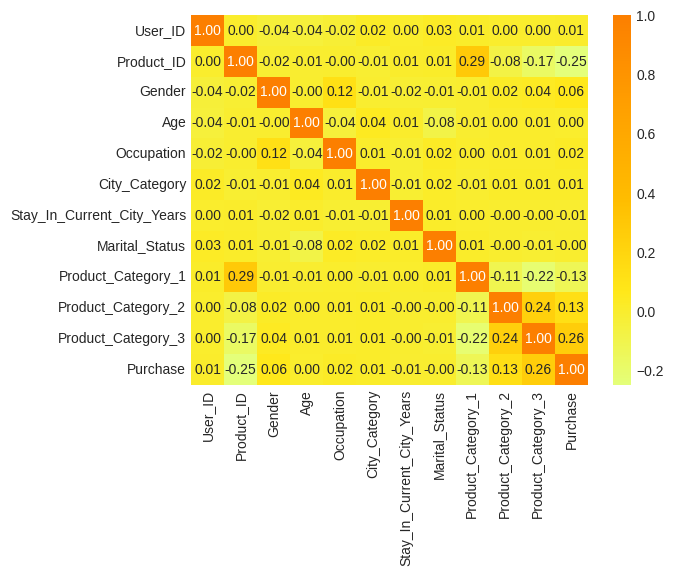

In [98]:
sns.heatmap(df2.corr(), annot = True, cmap= 'Wistia', fmt= '.2f')

**Мы видим, что возраст, пол и род занятий мало влияют на сумму покупки, в то время как категория товара и его идентификатор сильно влияют на сумму покупки**

# Создадим модель чтобы спрогнозировать количествр покупок:

**Прогноз множественной регрессии:**

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

**Настройка функций и целевых показателей**

In [100]:
X= df2.values[:,0:11]
Y= df2.values[:, 11]

In [101]:
X= preprocessing.scale(X)

**Разделяем наш шабор данных**

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 100)


**Обучаем модель:**

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor()

In [104]:
rfr.fit(X_train,y_train)

RandomForestRegressor()

**Предварительная точность нашей модели:**

In [105]:
score = rfr.score(X_train,y_train)
score

0.9582205675192365

**Тест на точность:**

In [106]:
y_pred5 = rfr.predict(X_test)
rscore=r2_score(y_test, y_pred5)
rscore

0.6984281408129553

In [107]:
df2['Prediction']=rfr.predict(X)


**Сравниваем спрогнозированные покупки с реальными:**

In [108]:
df2.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Prediction
0,0,0,0,0,10,0,0,0,0,-1,-1,8370,9164.29
1,0,1,0,0,10,0,0,0,1,0,0,15200,14977.81
2,0,2,0,0,10,0,0,0,2,-1,-1,1422,1419.83
3,0,3,0,0,10,0,0,0,2,1,-1,1057,1255.19
4,1,4,1,1,16,1,1,0,3,-1,-1,7969,7727.37
5,2,5,1,2,15,0,2,0,1,2,-1,15227,14732.25
6,3,6,1,3,7,2,0,1,1,3,1,19215,15116.10
7,3,7,1,3,7,2,0,1,1,4,-1,15854,15628.60
8,3,8,1,3,7,2,0,1,1,5,-1,15686,15531.71
9,4,9,1,2,20,0,3,1,3,-1,-1,7871,7329.58


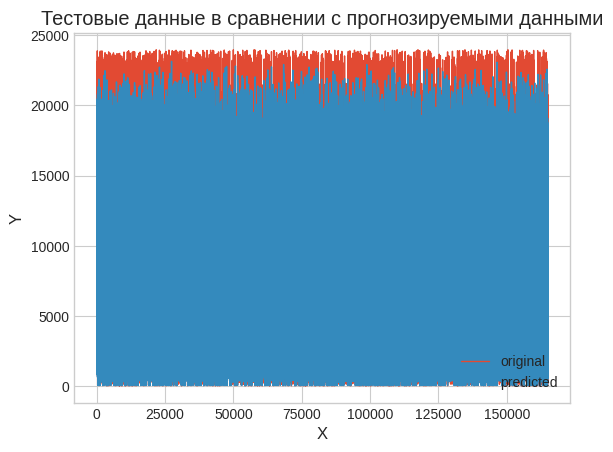

In [109]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth = '1', label="original")
plt.plot(x_ax, y_pred5, linewidth = '1', label="predicted")
plt.title("Тестовые данные в сравнении с прогнозируемыми данными")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='lower right',fancybox=True, shadow=True)
plt.show()

**Ноутбук демонстрирует полный цикл разработки модели машинного обучения: от предобработки данных и анализа до построения и оценки моделей, а также визуализации и интерпретации результатов.Модель случайного леса показала хорошие результаты, достигнув точности 70% на тестовом наборе данных. Этот результат указывает на приемлемую способность модели к обобщению**